# Aligning HST images to an absolute reference catalog
***

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, 'DrizzlePac' or 'Astroquery'.</div>

<div class="alert-warning">Note: This notebook is based on WFC3 ISR 2017-19: <a href="http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2017-19.pdf">Aligning HST Images to Gaia: a Faster Mosaicking Workflow</a> and contains a subset of the information/code found in <a href="https://github.com/spacetelescope/gaia_alignment">the repository here</a>.  For more information, see the notebook in that repository titled 'Gaia_alignment.ipynb'.</div>

## Introduction

The alignment of HST exposures is a critical step in image stacking/combination performed by software such as `AstroDrizzle`.  Generally, a relative alignment is performed that aligns one image (or multiple images) to another image which is designated as the reference image.  This makes it so the images are aligned to each other, but the pointing error of the observatory can still cause the images to have incorrect absolute astrometry.

When absolute astrometry is desired, the images can be aligned to an external catalog that is known to be on an absolute frame.  In this example, we will provide a workflow to query catalogs such as SDSS and Gaia via the astroquery package, and then align the images to that catalog via TweakReg.

For more information about TweakReg, see the other notebooks in this repository or the __[TweakReg Documentation](https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html)__.

For more information on Astroquery, see the other notebooks in this repository or the __[Astroquery Documentation](https://astroquery.readthedocs.io/en/latest/)__.

In [1]:
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from astroquery.sdss import SDSS

from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Download the Data
For this example, we will use WFC3/UVIS images of NGC 6791 from Visit 01 of proposal 12692.

In [2]:
# Get the observation records
obsTable = Observations.query_criteria(obs_id='ibwb01*', proposal_id=12692, obstype='all', filters='F606W')

# Get the listing of data products
products = Observations.get_product_list(obsTable)

# Filter the products for exposures
filtered_products = Observations.filter_products(products, productSubGroupDescription='FLC')

# Show the table
filtered_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str37,str64,str1,str97,str9,str28,str11,str1,str7,str19,str5,str52,int64,str8,str6,int64
26311101,HST,image,hst_12692_01_wfc3_uvis_f606w_ibwb01xq,HAP flat-field product,D,mast:HST/product/hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits,SCIENCE,--,FLC,--,HAP-SVM,DrizzlePac 3.6.2,12692,hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits,169263360,23896887,PUBLIC,2
26311085,HST,image,hst_12692_01_wfc3_uvis_f606w_ibwb01xr,HAP flat-field product,D,mast:HST/product/hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits,SCIENCE,--,FLC,--,HAP-SVM,DrizzlePac 3.6.2,12692,hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits,169148160,23896888,PUBLIC,2
26311106,HST,image,hst_12692_01_wfc3_uvis_f606w_ibwb01xx,HAP flat-field product,D,mast:HST/product/hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits,SCIENCE,--,FLC,--,HAP-SVM,DrizzlePac 3.6.2,12692,hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits,169263360,23896891,PUBLIC,2
23896887,HST,image,ibwb01xqq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xqq_flc.fits,SCIENCE,Minimum Recommended Products,FLC,--,CALWF3,3.7.1 (Oct-18-2023),12692,ibwb01xqq_flc.fits,169148160,23896887,PUBLIC,2
23896888,HST,image,ibwb01xrq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xrq_flc.fits,SCIENCE,Minimum Recommended Products,FLC,--,CALWF3,3.7.1 (Oct-18-2023),12692,ibwb01xrq_flc.fits,169032960,23896888,PUBLIC,2
23896891,HST,image,ibwb01xxq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xxq_flc.fits,SCIENCE,Minimum Recommended Products,FLC,--,CALWF3,3.7.1 (Oct-18-2023),12692,ibwb01xxq_flc.fits,169148160,23896891,PUBLIC,2


In [3]:
# Download all the images above
Observations.download_products(filtered_products, mrp_only=False)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str103,str8,object,object
./mastDownload/HST/hst_12692_01_wfc3_uvis_f606w_ibwb01xq/hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits,COMPLETE,None,None
./mastDownload/HST/hst_12692_01_wfc3_uvis_f606w_ibwb01xr/hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits,COMPLETE,None,None
./mastDownload/HST/hst_12692_01_wfc3_uvis_f606w_ibwb01xx/hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits,COMPLETE,None,None
./mastDownload/HST/ibwb01xqq/ibwb01xqq_flc.fits,COMPLETE,None,None
./mastDownload/HST/ibwb01xrq/ibwb01xrq_flc.fits,COMPLETE,None,None
./mastDownload/HST/ibwb01xxq/ibwb01xxq_flc.fits,COMPLETE,None,None


In [4]:
# For convenience, move the products into the current directory.
for flc in glob.glob('./mastDownload/HST/*/*flc.fits'):
    flc_name = os.path.split(flc)[-1]
    os.rename(flc, flc_name)

### Inspect the image header

The cell below shows how to query information from the image header using `ImageFileCollection` in `ccdproc`. 
We see that the 1st exposure is 30 seconds and the 2nd and 3rd exposures are 360 seconds. The 3rd exposure is dithered by ~82" in the Y-direction which is approximately the width of one UVIS chip. 

In [5]:
collec = ImageFileCollection('./', glob_include="*flc.fits", ext=0,
                             keywords=["targname", "ra_targ", "dec_targ", "filter", "exptime", "postarg1", "postarg2"])

table = collec.summary
table['exptime'].format = '7.1f'
table['ra_targ'].format = '7.7f'
table['dec_targ'].format = '7.7f'
table['postarg1'].format = '7.2f'
table['postarg2'].format = '7.2f'
table

file,targname,ra_targ,dec_targ,filter,exptime,postarg1,postarg2
str46,str8,float64,float64,str5,float64,float64,float64
hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,30.0,0.00,0.00
hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,0.00
hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,81.60
ibwb01xqq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,30.0,0.00,0.00
ibwb01xrq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,0.00
ibwb01xxq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,81.60


# 2. Querying catalogs

Now that we have the images, we will download the reference catalogs from both SDSS and Gaia using `astroquery`.

### 2a. Identify Coordinates
We will first create a SkyCoord Object to point astroquery to where we are looking on the sky.  Since our example uses data from NGC 6791, we will use the `ra_targ` and `dec_targ` keywords from the first image to get the coordinates of the object.

In [6]:
RA = table['ra_targ'][0]
Dec = table['dec_targ'][0]

### 2b. SDSS Query
We now give those values to an astropy `SkyCoord` object, which we will pass to the SDSS.  Additionally, we use an astropy `Quantity` object to create a radius for the SDSS query.  We set the radius to 6 arcminutes to comfortably cover the area of our images. For reference UVIS detector field of view is ~2.7'x2.7' and a y-dither of 82" covers a total area on the sky of ~2.7'x4.1'.

In [7]:
coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(6., u.arcmin)

Then we only need to perform the query via the `SDSS.query_region` method of `astroquery.sdss`. The `spectro=False` keyword argument means we want to exclude spectroscopic objects, as we are looking for objects to match with an image.  

In the fields parameter, we specify a list of fields we want returned by the query.  In this case we only need the position, and maybe a magnitude 'g' if we want to cut very dim and/or bright objects out of the catalog, as those are likely measured poorly. Details on selecting objects by magnitude may be found in the original ['Gaia_alignment' notebook](https://github.com/spacetelescope/gaia_alignment).  Many other fields are available in the SDSS query and are [documented here](http://cas.sdss.org/dr7/en/help/browser/description.asp?n=PhotoObj&t=V).

In [8]:
sdss_query = SDSS.query_region(coord, radius=radius, spectro=False, fields=['ra', 'dec', 'g'])
sdss_query

ra,dec,g
float64,float64,float64
290.207469231001,37.8165326473223,20.33007
290.271475371735,37.7300895794016,15.66874
290.309189927802,37.8278826035946,19.63535
290.163019147038,37.7061662746003,18.96654
290.20638291091,37.8578498261682,19.08411
290.217665348487,37.7344679199735,18.97118
290.28739975944,37.8760699685096,21.61839
290.320926423694,37.8576064635757,18.07215
290.133686795983,37.8548733101238,20.47255


We then just need to save the catalog to use with TweakReg.  Since the returned value of the query is an `astropy.Table`, saving the file is very straightforward:

In [9]:
sdss_query.write('sdss.cat', format='ascii.commented_header', overwrite=True)

### 2c. Gaia Query
Similarly to SDSS, we can query Gaia catalogs for our target via `astroquery.gaia`.  We can use the same `coord` and  `radius` from the SDSS query.

In [10]:
gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
gaia_query

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,solRad,solRad,solRad,solLum,solLum,solLum,,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object,float64
1635721458409799680,Gaia DR2 2051293319932402944,2051293319932402944,1675162907,2015.5,290.2248612117769,0.17025317759995298,37.801928644334666,0.23706526958649082,0.9169012687299769,0.2320288738061574,3.9516687,-0.7436331528144198,0.3812622579469638,6.010353940292694,0.5025560536657159,0.07765845,0.19423231,-0.002706211,-0.20296262,0.26506588,-0.22303766,-0.1096294,-0.17967537,-0.07058169,-0.061190978,215,0,214,1,1.9095645,249.77103,0.6411118327127229,1.2557711706373367,31,False,0.26720327,1.39814863054866,0.05706386095029324,0.05975954,25,15,0.44619527,0,27,False,230,476.3769381965007,1.1245576505069257,423.61273,18.993488,18,136.8471182536094,8.327590887105266,16.432978,20.0108,18,577.3836822334904,8.364935664317445,69.024284,17.85826,1.4992976,0,2.1525402,1.0173111,1.1352291,--,--,0,--,--,--,NOT_AVAILABLE,69.98761815072085,10.91419930893231,302.0419654146322,59.011908313993786,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+2051293319932402944,,0.0007457750280585006
1635721458409799680,Gaia DR2 2051293324218263808,2051293324218263808,1595923736,2015.5,290.223279633381,1.5690004116043692,37.80283985940256,1.6547840094163826,-1.320572176475729,1.8191390036660162,-0.7259

This query has returned very large number of columns. We want to pare down the catalog to make it easier to use with `TweakReg`.  
We can select only the useful columns via:

In [11]:
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query

ra,dec,phot_g_mean_mag
deg,deg,mag
float64,float64,float32
290.2248612117769,37.801928644334666,18.993488
290.223279633381,37.80283985940256,20.828722
290.2226200636918,37.80270788854854,16.649422
290.2248310561946,37.80058642553806,17.595186
290.2225603235312,37.8039787667679,18.654873
290.22681932060266,37.80112775249116,20.771065
290.2275250867832,37.80347302560439,19.938679
290.2242323214596,37.80039574182613,20.654758


Then we write this catalog to an ascii file for use with `TweakReg`.

In [12]:
reduced_query.write('gaia.cat', format='ascii.commented_header', overwrite=True)

## 3. Running TweakReg
With the catalogs downloaded and the headers populated, we simply need to run TweakReg with each catalog passed into the `refcat` parameter. The steps below compare the astrometric residuals obtained from aligning to each `refcat`. In each test case, we set `updatehdr` to False until we are satisfied with the alignment by inspecting both the shift file and the astrometric residual plots.

### 3a. SDSS Alignment

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 16:05:57.267 (06/02/2024) 


TweakReg Version 3.5.1 started at: 16:05:57.267 (06/02/2024) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 9.4.0]


Python Version [GCC 9.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:40:21) 


3.9.18 (main, Aug 28 2023, 08:40:21) 


INFO:drizzlepac.util:numpy Version -> 1.23.4 


numpy Version -> 1.23.4 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.10.0 


photutils Version -> 1.10.0 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	500.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 16:05:57.434 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 16:05:57.434 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920805


INFO:drizzlepac.catalogs:###Source finding finished at: 16:05:57.765 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 16:05:57.829 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 16:05:57.829 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796706


INFO:drizzlepac.catalogs:###Source finding finished at: 16:05:58.152 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 16:05:58.508 (06/02/2024)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 16:05:58.508 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845


INFO:drizzlepac.catalogs:###Source finding finished at: 16:05:58.834 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 16:05:58.897 (06/02/2024)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 16:05:58.897 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472357


INFO:drizzlepac.catalogs:###Source finding finished at: 16:05:59.302 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 16:05:59.690 (06/02/2024)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 16:05:59.690 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607799


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:00.005 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 16:06:00.065 (06/02/2024)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 16:06:00.065 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679644


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:00.37 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 16:06:00.796 (06/02/2024)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 16:06:00.796 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920805


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:01.115 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 16:06:01.17 (06/02/2024)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 16:06:01.17 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796706


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:01.502 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 16:06:01.867 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 16:06:01.867 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:02.194 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 16:06:02.259 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 16:06:02.259 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472357


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:02.583 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 16:06:02.975 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 16:06:02.975 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607799


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:03.28 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 16:06:03.349 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 16:06:03.349 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679644


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:03.659 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	4.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits'


derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	False


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	general


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	1.5


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	SDSS_shifts.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.908, -0.2667 with significance of 89.35 and 519 matches


Found initial X and Y shifts of 1.908, -0.2667 with significance of 89.35 and 519 matches


INFO:drizzlepac.imgclasses:Found 143 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits...


Found 143 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits : 


Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.4921  YSH: -0.4558    PROPER ROT: 359.9986475    


XSH: 1.4921  YSH: -0.4558    PROPER ROT: 359.9986475    


INFO:drizzlepac.imgclasses:<ROT>: 359.9986475  SKEW: -6.804118777e-05    ROT_X: 359.9986815  ROT_Y: 359.9986135


<ROT>: 359.9986475  SKEW: -6.804118777e-05    ROT_X: 359.9986815  ROT_Y: 359.9986135


INFO:drizzlepac.imgclasses:<SCALE>: 1.00002879  SCALE_X: 0.9999996396  SCALE_Y: 1.000057941


<SCALE>: 1.00002879  SCALE_X: 0.9999996396  SCALE_Y: 1.000057941


INFO:drizzlepac.imgclasses:FIT XRMS: 0.37       FIT YRMS: 0.44   


FIT XRMS: 0.37       FIT YRMS: 0.44   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.58       FIT MAE: 0.51   


FIT RMSE: 0.58       FIT MAE: 0.51   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8e-06 (deg)   RMS_DEC: 7.1e-07 (deg)


RMS_RA: 8e-06 (deg)   RMS_DEC: 7.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  143  objects.


Final solution based on  143  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc_catalog_fit.match


wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 143


Total # points: 143


INFO:drizzlepac.tweakutils:# of points after clipping: 143


# of points after clipping: 143


INFO:drizzlepac.tweakutils:Total # points: 143


Total # points: 143


INFO:drizzlepac.tweakutils:# of points after clipping: 143


# of points after clipping: 143


INFO:drizzlepac.updatehdr:....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' ...


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.898, 0.8129 with significance of 81.85 and 545 matches


Found initial X and Y shifts of 1.898, 0.8129 with significance of 81.85 and 545 matches


INFO:drizzlepac.imgclasses:Found 149 matches for ibwb01xqq_flc.fits...


Found 149 matches for ibwb01xqq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xqq_flc.fits : 


Computed  general  fit for  ibwb01xqq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.3771  YSH: 0.8051    PROPER ROT: 0.001423943645    


XSH: 1.3771  YSH: 0.8051    PROPER ROT: 0.001423943645    


INFO:drizzlepac.imgclasses:<ROT>: 180.0014239  SKEW: -359.9935648    ROT_X: 359.9982063  ROT_Y: 0.004641557185


<ROT>: 180.0014239  SKEW: -359.9935648    ROT_X: 359.9982063  ROT_Y: 0.004641557185


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999249847  SCALE_X: 1.000030633  SCALE_Y: 0.9998193543


<SCALE>: 0.9999249847  SCALE_X: 1.000030633  SCALE_Y: 0.9998193543


INFO:drizzlepac.imgclasses:FIT XRMS: 0.35       FIT YRMS: 0.29   


FIT XRMS: 0.35       FIT YRMS: 0.29   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.45       FIT MAE: 0.39   


FIT RMSE: 0.45       FIT MAE: 0.39   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.1e-06 (deg)   RMS_DEC: 1.4e-06 (deg)


RMS_RA: 6.1e-06 (deg)   RMS_DEC: 1.4e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  145  objects.


Final solution based on  145  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 145


Total # points: 145


INFO:drizzlepac.tweakutils:# of points after clipping: 145


# of points after clipping: 145


INFO:drizzlepac.tweakutils:Total # points: 145


Total # points: 145


INFO:drizzlepac.tweakutils:# of points after clipping: 145


# of points after clipping: 145


INFO:drizzlepac.updatehdr:....Updating header for 'ibwb01xqq_flc.fits' ...


INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.88, 0.6122 with significance of 71.82 and 533 matches


Found initial X and Y shifts of 1.88, 0.6122 with significance of 71.82 and 533 matches


INFO:drizzlepac.imgclasses:Found 154 matches for ibwb01xrq_flc.fits...


Found 154 matches for ibwb01xrq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xrq_flc.fits : 


Computed  general  fit for  ibwb01xrq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.4163  YSH: 0.6137    PROPER ROT: 0.0005587351581    


XSH: 1.4163  YSH: 0.6137    PROPER ROT: 0.0005587351581    


INFO:drizzlepac.imgclasses:<ROT>: 180.0005587  SKEW: -359.9946255    ROT_X: 359.9978715  ROT_Y: 0.003246005389


<ROT>: 180.0005587  SKEW: -359.9946255    ROT_X: 359.9978715  ROT_Y: 0.003246005389


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999512799  SCALE_X: 1.000019332  SCALE_Y: 0.9998832367


<SCALE>: 0.9999512799  SCALE_X: 1.000019332  SCALE_Y: 0.9998832367


INFO:drizzlepac.imgclasses:FIT XRMS: 0.36       FIT YRMS: 0.34   


FIT XRMS: 0.36       FIT YRMS: 0.34   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.49       FIT MAE: 0.43   


FIT RMSE: 0.49       FIT MAE: 0.43   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.7e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


RMS_RA: 6.7e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  151  objects.


Final solution based on  151  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 151


Total # points: 151


INFO:drizzlepac.tweakutils:# of points after clipping: 151


# of points after clipping: 151


INFO:drizzlepac.tweakutils:Total # points: 151


Total # points: 151


INFO:drizzlepac.tweakutils:# of points after clipping: 151


# of points after clipping: 151


INFO:drizzlepac.updatehdr:....Updating header for 'ibwb01xrq_flc.fits' ...


INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.945, -0.135 with significance of 87.93 and 510 matches


Found initial X and Y shifts of 1.945, -0.135 with significance of 87.93 and 510 matches


INFO:drizzlepac.imgclasses:Found 117 matches for ibwb01xxq_flc.fits...


Found 117 matches for ibwb01xxq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xxq_flc.fits : 


Computed  general  fit for  ibwb01xxq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.5829  YSH: -0.1776    PROPER ROT: 359.9994678    


XSH: 1.5829  YSH: -0.1776    PROPER ROT: 359.9994678    


INFO:drizzlepac.imgclasses:<ROT>: 359.9994678  SKEW: 0.0001464037783    ROT_X: 359.9993946  ROT_Y: 359.999541


<ROT>: 359.9994678  SKEW: 0.0001464037783    ROT_X: 359.9993946  ROT_Y: 359.999541


INFO:drizzlepac.imgclasses:<SCALE>: 1.000054292  SCALE_X: 0.9999822928  SCALE_Y: 1.000126295


<SCALE>: 1.000054292  SCALE_X: 0.9999822928  SCALE_Y: 1.000126295


INFO:drizzlepac.imgclasses:FIT XRMS: 0.38       FIT YRMS: 0.53   


FIT XRMS: 0.38       FIT YRMS: 0.53   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.65       FIT MAE: 0.59   


FIT RMSE: 0.65       FIT MAE: 0.59   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9e-06 (deg)   RMS_DEC: 2.4e-07 (deg)


RMS_RA: 9e-06 (deg)   RMS_DEC: 2.4e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  116  objects.


Final solution based on  116  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 116


Total # points: 116


INFO:drizzlepac.tweakutils:# of points after clipping: 116


# of points after clipping: 116


INFO:drizzlepac.tweakutils:Total # points: 116


Total # points: 116


INFO:drizzlepac.tweakutils:# of points after clipping: 116


# of points after clipping: 116


INFO:drizzlepac.updatehdr:....Updating header for 'ibwb01xxq_flc.fits' ...


INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.933, 2.08 with significance of 75.87 and 542 matches


Found initial X and Y shifts of 1.933, 2.08 with significance of 75.87 and 542 matches


INFO:drizzlepac.imgclasses:Found 27 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits...


Found 27 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits : 


Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.5084  YSH: 1.7853    PROPER ROT: 0.0004782092997    


XSH: 1.5084  YSH: 1.7853    PROPER ROT: 0.0004782092997    


INFO:drizzlepac.imgclasses:<ROT>: 180.0004782  SKEW: -359.9942347    ROT_X: 359.9975956  ROT_Y: 0.003360847266


<ROT>: 180.0004782  SKEW: -359.9942347    ROT_X: 359.9975956  ROT_Y: 0.003360847266


INFO:drizzlepac.imgclasses:<SCALE>: 1.000091848  SCALE_X: 1.00013505  SCALE_Y: 1.000048652


<SCALE>: 1.000091848  SCALE_X: 1.00013505  SCALE_Y: 1.000048652


INFO:drizzlepac.imgclasses:FIT XRMS: 0.39       FIT YRMS: 0.42   


FIT XRMS: 0.39       FIT YRMS: 0.42   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.57       FIT MAE: 0.52   


FIT RMSE: 0.57       FIT MAE: 0.52   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.9e-06 (deg)   RMS_DEC: 1e-06 (deg)


RMS_RA: 7.9e-06 (deg)   RMS_DEC: 1e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  27  objects.


Final solution based on  27  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc_catalog_fit.match


wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 27


Total # points: 27


INFO:drizzlepac.tweakutils:# of points after clipping: 27


# of points after clipping: 27


INFO:drizzlepac.tweakutils:Total # points: 27


Total # points: 27


INFO:drizzlepac.tweakutils:# of points after clipping: 27


# of points after clipping: 27


INFO:drizzlepac.updatehdr:....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' ...


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.938, 0.2204 with significance of 64.95 and 536 matches


Found initial X and Y shifts of 1.938, 0.2204 with significance of 64.95 and 536 matches


INFO:drizzlepac.imgclasses:Found 170 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits...


Found 170 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits : 


Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.5816  YSH: 0.3103    PROPER ROT: 359.9981188    


XSH: 1.5816  YSH: 0.3103    PROPER ROT: 359.9981188    


INFO:drizzlepac.imgclasses:<ROT>: 359.9981188  SKEW: 0.002095650691    ROT_X: 359.997071  ROT_Y: 359.9991667


<ROT>: 359.9981188  SKEW: 0.002095650691    ROT_X: 359.997071  ROT_Y: 359.9991667


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999938703  SCALE_X: 1.000029499  SCALE_Y: 0.9999582434


<SCALE>: 0.9999938703  SCALE_X: 1.000029499  SCALE_Y: 0.9999582434


INFO:drizzlepac.imgclasses:FIT XRMS: 0.34       FIT YRMS: 0.49   


FIT XRMS: 0.34       FIT YRMS: 0.49   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.6        FIT MAE: 0.56   


FIT RMSE: 0.6        FIT MAE: 0.56   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8.3e-06 (deg)   RMS_DEC: 1e-07 (deg)


RMS_RA: 8.3e-06 (deg)   RMS_DEC: 1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  167  objects.


Final solution based on  167  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 167


Total # points: 167


INFO:drizzlepac.tweakutils:# of points after clipping: 167


# of points after clipping: 167


INFO:drizzlepac.tweakutils:Total # points: 167


Total # points: 167


INFO:drizzlepac.tweakutils:# of points after clipping: 167


# of points after clipping: 167


INFO:drizzlepac.updatehdr:....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' ...


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[4]


INFO:drizzlepac.tweakutils:Writing out shiftfile : SDSS_shifts.txt


Writing out shiftfile : SDSS_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


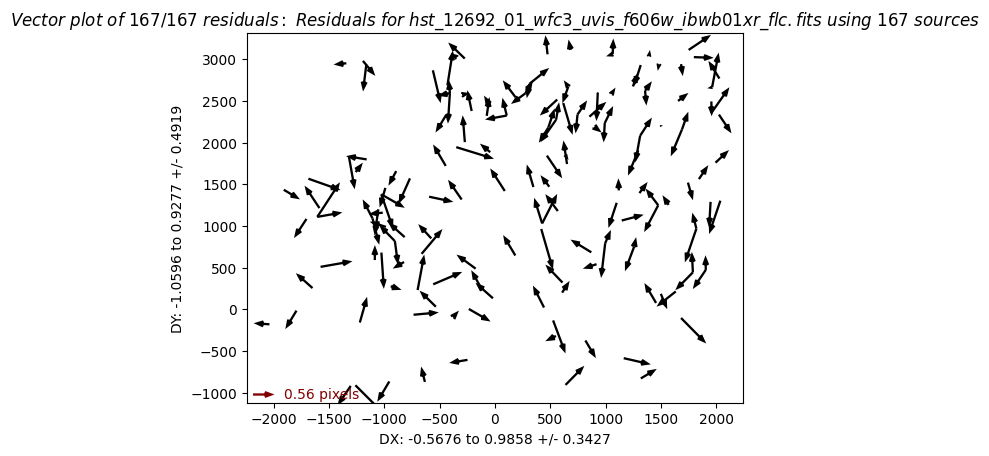

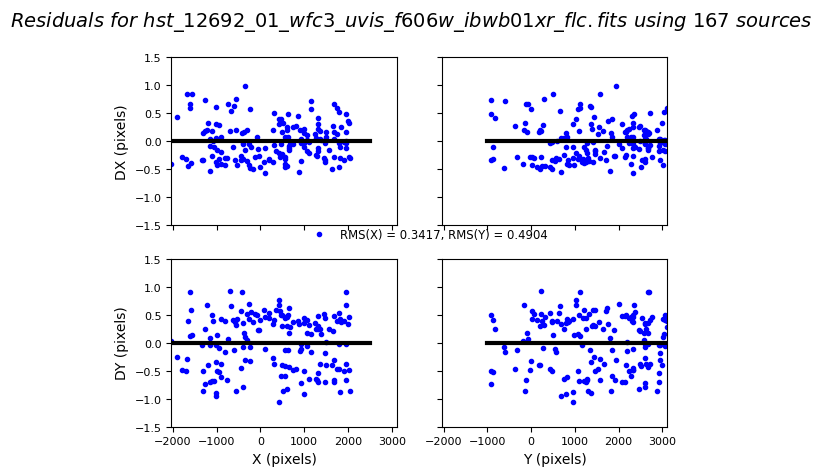

In [13]:
refcat = 'sdss.cat'
cw = 3.5  # Set to two times the FWHM of the PSF of the UVIS detector
wcsname = 'SDSS'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=False,  # update header with new WCS solution
                  imagefindcfg={'threshold': 500., 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='SDSS_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  ylimit=1.5,
                  fitgeometry='general')  # Use the 6 parameter fit

We can look at the shift file to see how well the fit did (or we could open the output png images for more information).

The columns are:
- Filename
- X Shift [pixels]
- Y Shift [pixels]
- Rotation [degrees]
- Scale
- X RMS [pixels]
- Y RMS [pixels]

In [14]:
for line in open('SDSS_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits    1.492130  -0.455806    359.998647     1.000029   0.374774  0.440129

ibwb01xqq_flc.fits    1.377062  0.805137    0.001424     0.999925   0.348594  0.291873

ibwb01xrq_flc.fits    1.416345  0.613736    0.000559     0.999951   0.360269  0.338378

ibwb01xxq_flc.fits    1.582912  -0.177647    359.999468     1.000054   0.380477  0.525550

hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits    1.508441  1.785289    0.000478     1.000092   0.393791  0.417064

hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits    1.581614  0.310348    359.998119     0.999994   0.341678  0.490401



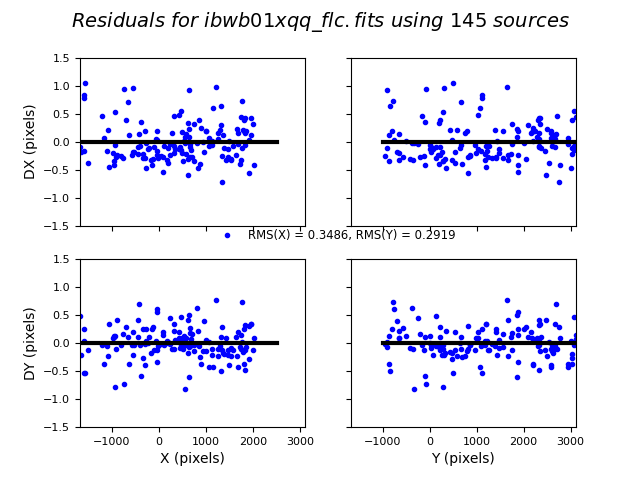

In [15]:
# Astrometric residual plots
Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

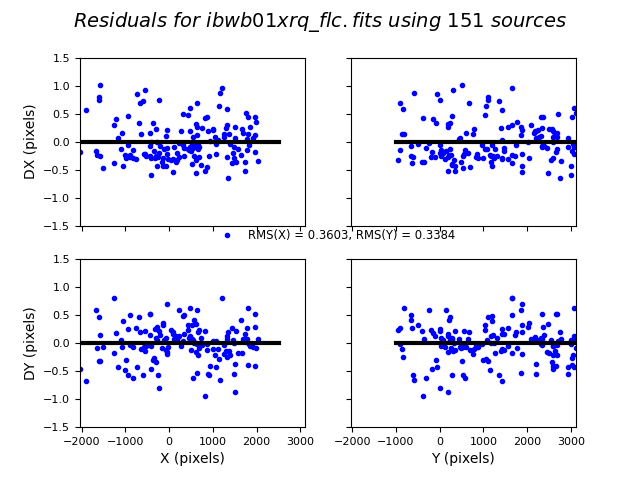

In [16]:
Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

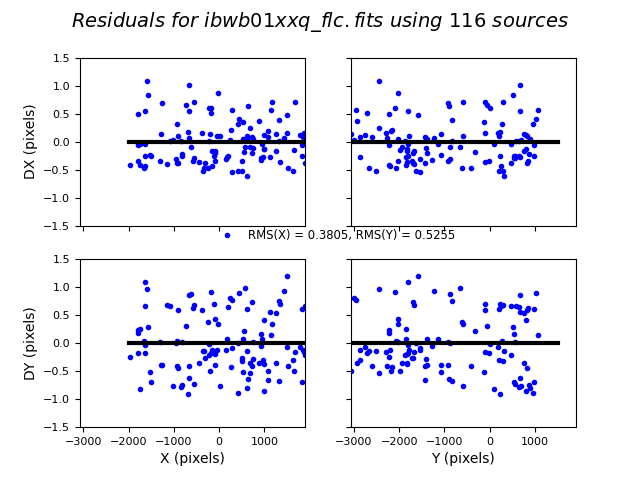

In [17]:
Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As we can see, the RMS is fairly large at about 0.5 pixels, which is not a great fit. This is likely because the SDSS astrometric precision is not high enough to get good HST alignment. One approach would be to align the first image to SDSS and then align the remaining HST images to one another. This would improve both the absolute and relative alignment of the individual frames.

### 3b. Gaia Alignment

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 16:06:10.666 (06/02/2024) 


TweakReg Version 3.5.1 started at: 16:06:10.666 (06/02/2024) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 9.4.0]


Python Version [GCC 9.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:40:21) 


3.9.18 (main, Aug 28 2023, 08:40:21) 


INFO:drizzlepac.util:numpy Version -> 1.23.4 


numpy Version -> 1.23.4 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.10.0 


photutils Version -> 1.10.0 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	500.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 16:06:10.831 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 16:06:10.831 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920805


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:11.154 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 16:06:11.220 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 16:06:11.220 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796706


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:11.546 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 16:06:11.909 (06/02/2024)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 16:06:11.909 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:12.235 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 16:06:12.299 (06/02/2024)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 16:06:12.299 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472357


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:12.628 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 16:06:13.016 (06/02/2024)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 16:06:13.016 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607799


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:13.329 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 16:06:13.487 (06/02/2024)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 16:06:13.487 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679644


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:13.798 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 16:06:14.224 (06/02/2024)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 16:06:14.224 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920805


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:14.545 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 16:06:14.609 (06/02/2024)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 16:06:14.609 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796706


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:14.934 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 16:06:15.301 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 16:06:15.301 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:15.62 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 16:06:15.696 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 16:06:15.696 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472357


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:16.021 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 16:06:16.417 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 16:06:16.417 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607799


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:16.729 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 16:06:16.793 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 16:06:16.793 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679644


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:17.104 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	4.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits'


derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	False


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	general


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	2.3


INFO:drizzlepac.tweakreg:	ylimit :	0.2


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	Gaia_shifts.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xqq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xqq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xrq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xrq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xxq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xxq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


INFO:drizzlepac.imgclasses:Found 31 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits...


Found 31 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits : 


Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1818  YSH: 0.2966    PROPER ROT: 0.0002519310155    


XSH: -0.1818  YSH: 0.2966    PROPER ROT: 0.0002519310155    


INFO:drizzlepac.imgclasses:<ROT>: 0.0002519310155  SKEW: -0.0002358000364    ROT_X: 0.0003698310337  ROT_Y: 0.0001340309973


<ROT>: 0.0002519310155  SKEW: -0.0002358000364    ROT_X: 0.0003698310337  ROT_Y: 0.0001340309973


INFO:drizzlepac.imgclasses:<SCALE>: 1.000018957  SCALE_X: 1.000019136  SCALE_Y: 1.000018779


<SCALE>: 1.000018957  SCALE_X: 1.000019136  SCALE_Y: 1.000018779


INFO:drizzlepac.imgclasses:FIT XRMS: 0.019      FIT YRMS: 0.023  


FIT XRMS: 0.019      FIT YRMS: 0.023  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.03       FIT MAE: 0.026  


FIT RMSE: 0.03       FIT MAE: 0.026  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.2e-07 (deg)   RMS_DEC: 3.1e-08 (deg)


RMS_RA: 4.2e-07 (deg)   RMS_DEC: 3.1e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  25  objects.


Final solution based on  25  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 25


Total # points: 25


INFO:drizzlepac.tweakutils:# of points after clipping: 25


# of points after clipping: 25


INFO:drizzlepac.tweakutils:Total # points: 25


Total # points: 25


INFO:drizzlepac.tweakutils:# of points after clipping: 25


# of points after clipping: 25


INFO:drizzlepac.updatehdr:....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' ...


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Unable to match the following images:


Unable to match the following images:


INFO:drizzlepac.tweakreg:-------------------------------------


-------------------------------------


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xqq_flc.fits


ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xrq_flc.fits


ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xxq_flc.fits


ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakutils:Writing out shiftfile : Gaia_shifts.txt


Writing out shiftfile : Gaia_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


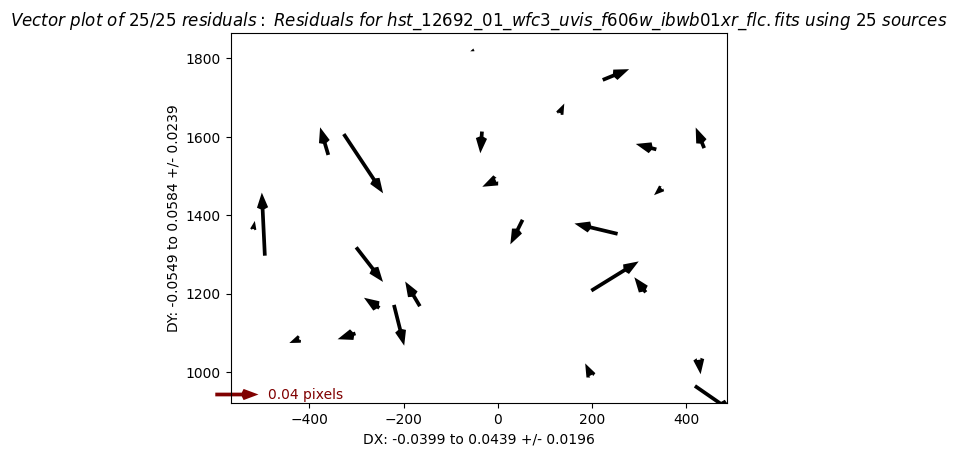

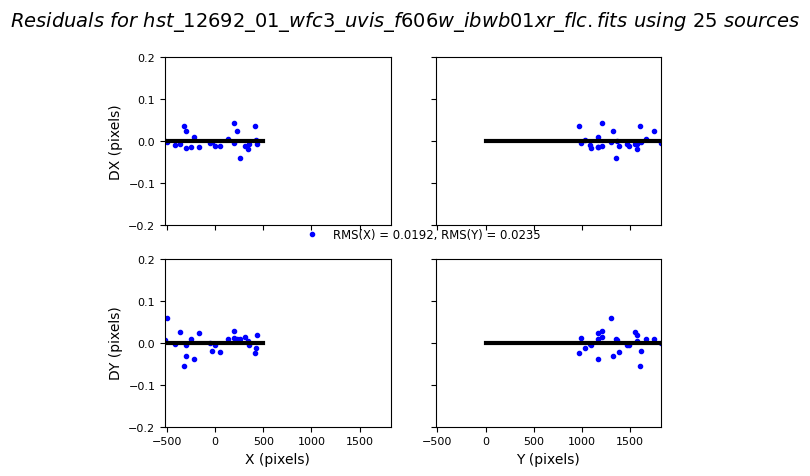

In [18]:
refcat = 'gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=False,  # update header with new WCS solution
                  imagefindcfg={'threshold':500.,'conv_width':cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  ylimit=0.2,
                  fitgeometry='general')  # Use the 6 parameter fit

We can similarly look at the shift file from alignment to the Gaia catalog:

In [19]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits    nan  nan    nan     nan   0.000000  0.000000

ibwb01xqq_flc.fits    nan  nan    nan     nan   0.000000  0.000000

ibwb01xrq_flc.fits    nan  nan    nan     nan   0.000000  0.000000

ibwb01xxq_flc.fits    nan  nan    nan     nan   0.000000  0.000000

hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits    nan  nan    nan     nan   0.000000  0.000000

hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits    -0.181808  0.296596    0.000252     1.000019   0.019181  0.023450



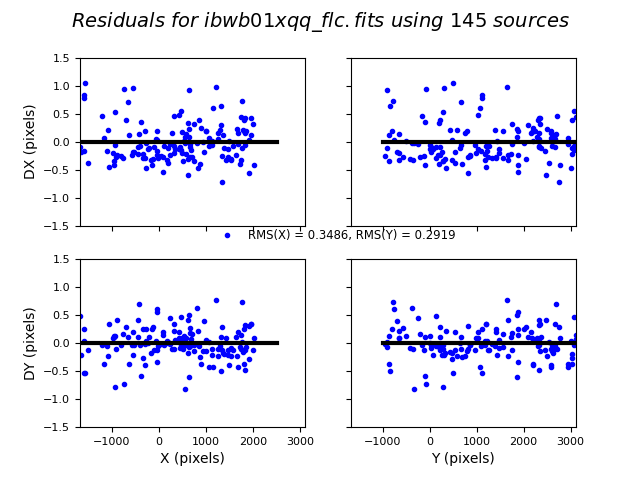

In [20]:
# Astrometric residual plots
Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

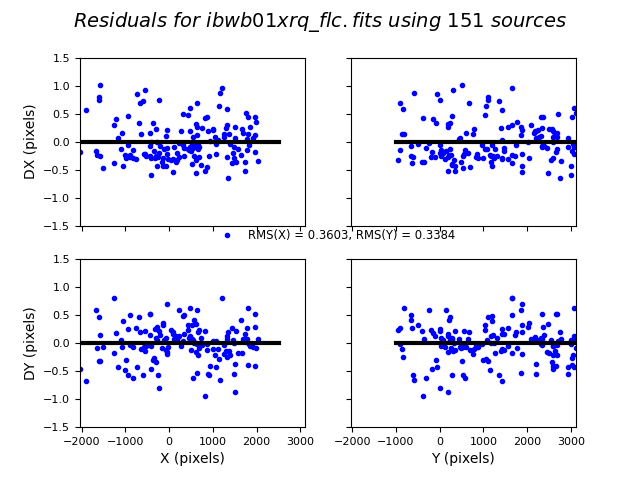

In [21]:
Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

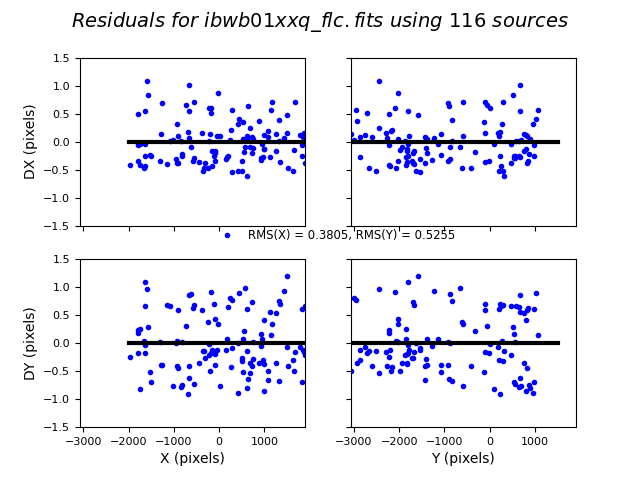

In [22]:
Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As expected, the Gaia catalog does quite a bit better, with rms residuals less tha 0.05 pixels.  

To apply these transformations to the image, we simply need to run TweakReg the same as before, but set the parameter `updatehdr` equal to `True`:

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 16:06:19.017 (06/02/2024) 


TweakReg Version 3.5.1 started at: 16:06:19.017 (06/02/2024) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 9.4.0]


Python Version [GCC 9.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:40:21) 


3.9.18 (main, Aug 28 2023, 08:40:21) 


INFO:drizzlepac.util:numpy Version -> 1.23.4 


numpy Version -> 1.23.4 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.10.0 


photutils Version -> 1.10.0 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	500.0


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 16:06:19.473 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 16:06:19.473 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920805


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:19.795 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 16:06:19.859 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 16:06:19.859 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796706


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:20.18 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 16:06:20.569 (06/02/2024)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 16:06:20.569 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:20.896 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 16:06:20.95 (06/02/2024)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 16:06:20.95 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472357


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:21.288 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 16:06:21.80 (06/02/2024)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 16:06:21.80 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607799


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:22.119 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 16:06:22.180 (06/02/2024)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 16:06:22.180 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679644


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:22.491 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 16:06:22.94 (06/02/2024)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 16:06:22.94 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920805


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:23.269 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 16:06:23.334 (06/02/2024)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 16:06:23.334 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796706


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:23.660 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 16:06:24.059 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 16:06:24.059 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:24.389 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 16:06:24.458 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 16:06:24.458 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472357


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:24.785 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 16:06:25.20 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 16:06:25.20 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607799


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:25.519 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 16:06:25.583 (06/02/2024)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 16:06:25.583 (06/02/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679644


INFO:drizzlepac.catalogs:###Source finding finished at: 16:06:25.892 (06/02/2024)


INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	4.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits'


derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	False


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	general


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	2.3


INFO:drizzlepac.tweakreg:	ylimit :	None


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	Gaia_shifts.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xqq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xqq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xrq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xrq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xxq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xxq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


INFO:drizzlepac.imgclasses:Found 31 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits...


Found 31 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits : 


Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1818  YSH: 0.2966    PROPER ROT: 0.0002519310155    


XSH: -0.1818  YSH: 0.2966    PROPER ROT: 0.0002519310155    


INFO:drizzlepac.imgclasses:<ROT>: 0.0002519310155  SKEW: -0.0002358000364    ROT_X: 0.0003698310337  ROT_Y: 0.0001340309973


<ROT>: 0.0002519310155  SKEW: -0.0002358000364    ROT_X: 0.0003698310337  ROT_Y: 0.0001340309973


INFO:drizzlepac.imgclasses:<SCALE>: 1.000018957  SCALE_X: 1.000019136  SCALE_Y: 1.000018779


<SCALE>: 1.000018957  SCALE_X: 1.000019136  SCALE_Y: 1.000018779


INFO:drizzlepac.imgclasses:FIT XRMS: 0.019      FIT YRMS: 0.023  


FIT XRMS: 0.019      FIT YRMS: 0.023  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.03       FIT MAE: 0.026  


FIT RMSE: 0.03       FIT MAE: 0.026  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.2e-07 (deg)   RMS_DEC: 3.1e-08 (deg)


RMS_RA: 4.2e-07 (deg)   RMS_DEC: 3.1e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  25  objects.


Final solution based on  25  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 25


Total # points: 25


INFO:drizzlepac.tweakutils:# of points after clipping: 25


# of points after clipping: 25


INFO:drizzlepac.tweakutils:Total # points: 25


Total # points: 25


INFO:drizzlepac.tweakutils:# of points after clipping: 25


# of points after clipping: 25


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' ...


....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',1]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[1]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7147485444409156e-06 -9.202673432426801e-06


CD_11  CD_12: -6.7147485444409156e-06 -9.202673432426801e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.798417099674189e-06 6.145457685317562e-06


CD_21  CD_22: -8.798417099674189e-06 6.145457685317562e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.2399022652498 37.79473460219952


CRVAL    : 290.2399022652498 37.79473460219952


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984544996051754


Plate Scale : 0.03984544996051754


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.265378166586416


ORIENTAT : -56.265378166586416


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',2]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[4]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.731833077301151e-06 -9.088554415222168e-06


CD_11  CD_12: -6.731833077301151e-06 -9.088554415222168e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.708163913459483e-06 6.080926838292377e-06


CD_21  CD_22: -8.708163913459483e-06 6.080926838292377e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.215811381047 37.80746944924112


CRVAL    : 290.215811381047 37.80746944924112


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962523566481383


Plate Scale : 0.03962523566481383


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.214498950289105


ORIENTAT : -56.214498950289105


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Unable to match the following images:


Unable to match the following images:


INFO:drizzlepac.tweakreg:-------------------------------------


-------------------------------------


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xqq_flc.fits


ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xrq_flc.fits


ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xxq_flc.fits


ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',1]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[('SCI', 1)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7168289797092e-06 -9.2014331418027e-06


CD_11  CD_12: -6.7168289797092e-06 -9.2014331418027e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.797041438879e-06 6.1476759033389e-06


CD_21  CD_22: -8.797041438879e-06 6.1476759033389e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.26373951085 37.782120708235


CRVAL    : 290.26373951085 37.782120708235


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0398453050669135


Plate Scale : 0.0398453050669135


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.25226080561179


ORIENTAT : -56.25226080561179


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',2]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[('SCI', 2)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7338948386884e-06 -9.0873259238427e-06


CD_11  CD_12: -6.7338948386884e-06 -9.0873259238427e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7067816506993e-06 6.0831191403985e-06


CD_21  CD_22: -8.7067816506993e-06 6.0831191403985e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23965599298 37.794860145407


CRVAL    : 290.23965599298 37.794860145407


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962509164522688


Plate Scale : 0.03962509164522688


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.20137293532625


ORIENTAT : -56.20137293532625


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xqq_flc.fits['SCI',1]


Processing ibwb01xqq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[('SCI', 1)]


Updating header for ibwb01xqq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7144729534338e-06 -9.2025390369227e-06


CD_11  CD_12: -6.7144729534338e-06 -9.2025390369227e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7983172736348e-06 6.1452321678657e-06


CD_21  CD_22: -8.7983172736348e-06 6.1452321678657e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23990246669 37.794737696364


CRVAL    : 290.23990246669 37.794737696364


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984380954694909


Plate Scale : 0.03984380954694909


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.26596277943587


ORIENTAT : -56.26596277943587


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xqq_flc.fits['SCI',2]


Processing ibwb01xqq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[('SCI', 2)]


Updating header for ibwb01xqq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7315583299646e-06 -9.08842185479e-06


CD_11  CD_12: -6.7315583299646e-06 -9.08842185479e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7080660473722e-06 6.0807039098969e-06


CD_21  CD_22: -8.7080660473722e-06 6.0807039098969e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.21581193297 37.807472076506


CRVAL    : 290.21581193297 37.807472076506


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962360435628055


Plate Scale : 0.03962360435628055


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.21508352145832


ORIENTAT : -56.21508352145832


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xrq_flc.fits['SCI',1]


Processing ibwb01xrq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[('SCI', 1)]


Updating header for ibwb01xrq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7144223626035e-06 -9.2025672352133e-06


CD_11  CD_12: -6.7144223626035e-06 -9.2025672352133e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7983428376788e-06 6.1451839680646e-06


CD_21  CD_22: -8.7983428376788e-06 6.1451839680646e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.2399022797 37.794737100123


CRVAL    : 290.2399022797 37.794737100123


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984377221614212


Plate Scale : 0.03984377221614212


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.26625140733006


ORIENTAT : -56.26625140733006


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xrq_flc.fits['SCI',2]


Processing ibwb01xrq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[('SCI', 2)]


Updating header for ibwb01xrq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7315081936046e-06 -9.0884497391215e-06


CD_11  CD_12: -6.7315081936046e-06 -9.0884497391215e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7080917574507e-06 6.0806562885776e-06


CD_21  CD_22: -8.7080917574507e-06 6.0806562885776e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.21581167225 37.807471380532


CRVAL    : 290.21581167225 37.807471380532


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0396235671972254


Plate Scale : 0.0396235671972254


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.21537215052241


ORIENTAT : -56.21537215052241


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xxq_flc.fits['SCI',1]


Processing ibwb01xxq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[('SCI', 1)]


Updating header for ibwb01xxq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7163876978578e-06 -9.2012701929559e-06


CD_11  CD_12: -6.7163876978578e-06 -9.2012701929559e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7968793763263e-06 6.1472634516411e-06


CD_21  CD_22: -8.7968793763263e-06 6.1472634516411e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.2637406649 37.78212037626


CRVAL    : 290.2637406649 37.78212037626


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984387729734187


Plate Scale : 0.03984387729734187


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.25356779852638


ORIENTAT : -56.25356779852638


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xxq_flc.fits['SCI',2]


Processing ibwb01xxq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[('SCI', 2)]


Updating header for ibwb01xxq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7334552109948e-06 -9.0871652626458e-06


CD_11  CD_12: -6.7334552109948e-06 -9.0871652626458e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7066230727137e-06 6.0827114252465e-06


CD_21  CD_22: -8.7066230727137e-06 6.0827114252465e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23965757309 37.794858959514


CRVAL    : 290.23965757309 37.794858959514


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039623671828060494


Plate Scale : 0.039623671828060494


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.202679900910084


ORIENTAT : -56.202679900910084


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',1]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[('SCI', 1)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7149309464166e-06 -9.202825082356e-06


CD_11  CD_12: -6.7149309464166e-06 -9.202825082356e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7985956289444e-06 6.1456579607119e-06


CD_21  CD_22: -8.7985956289444e-06 6.1456579607119e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23990087835 37.794738672696


CRVAL    : 290.23990087835 37.794738672696


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984560642319833


Plate Scale : 0.03984560642319833


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.26495187673453


ORIENTAT : -56.26495187673453


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',2]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[('SCI', 2)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7320153051525e-06 -9.0887041784574e-06


CD_11  CD_12: -6.7320153051525e-06 -9.0887041784574e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7083401696135e-06 6.081124874862e-06


CD_21  CD_22: -8.7083401696135e-06 6.081124874862e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.21580959584 37.80747393454


CRVAL    : 290.21580959584 37.80747393454


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962539126339966


Plate Scale : 0.03962539126339966


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.21407292058708


ORIENTAT : -56.21407292058708


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


INFO:drizzlepac.tweakutils:Writing out shiftfile : Gaia_shifts.txt


Writing out shiftfile : Gaia_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


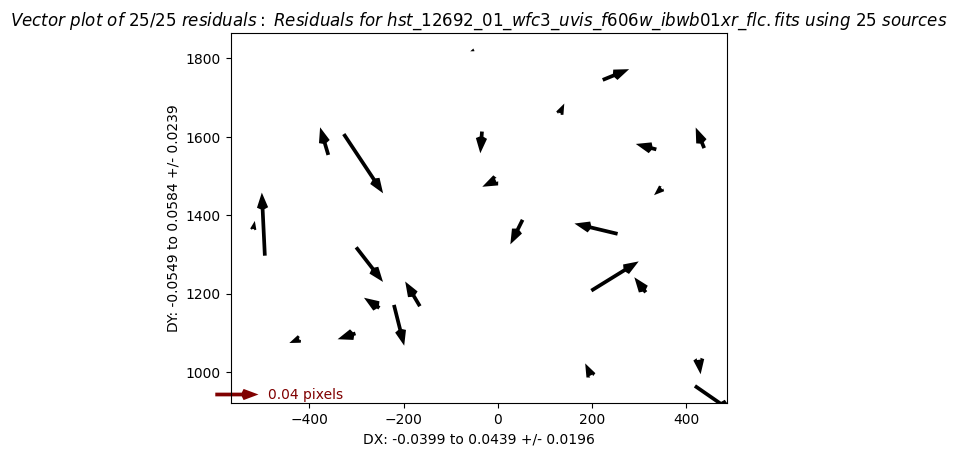

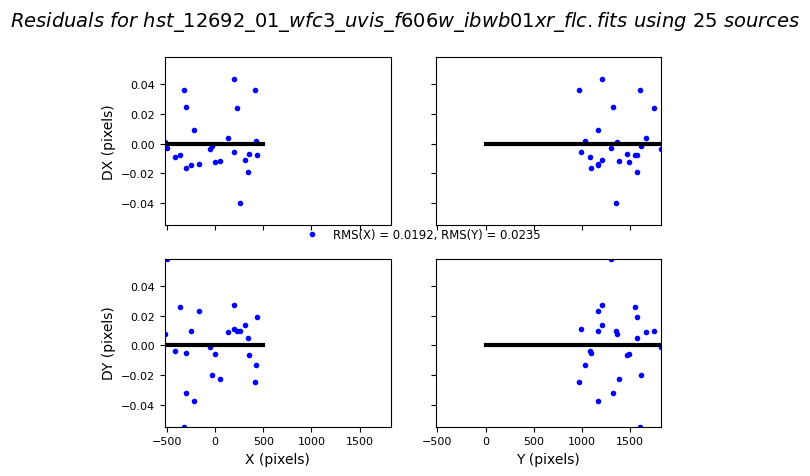

In [23]:
refcat = 'gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold': 500., 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  fitgeometry='general')  # Use the 6 parameter fit

## 4. Drizzle the Data

While the three sets of FLC files are now aligned, we drizzle together only the two long exposures. 

When exposures are very different lengths, drizzling them together doesn't work well when 'EXP' weighting is used. For objects that saturate in the long exposures, the problem occurs at the boundary where you transition from only short exposure to short plus long. Here the pixels getting power from long exposure pixels are only getting power from pixels whose centers are outside the ring, and thus they are weighted lower than they would be if they were getting values from both inside and outside the ring. The result is a discontinuity in the PSF radial profile and a resulting flux which is too low in those boundary pixels. For photometry of saturated objects, the short exposures should be drizzled separately from the long exposures. 

In [24]:
astrodrizzle.AstroDrizzle('ibwb01x[rx]q_flc.fits', 
                          output='f606w',
                          preserve=False,
                          clean=True, 
                          build=False,
                          context=False,
                          skymethod='match',
                          driz_sep_bits='64, 32',
                          combine_type='minmed',
                          final_bits='64, 32')

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 16:06:29.445 (06/02/2024)


AstroDrizzle Version 3.5.1 started at: 16:06:29.445 (06/02/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 9.4.0]


INFO:drizzlepac.astrodrizzle:3.9.18 (main, Aug 28 2023, 08:40:21) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.23.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 5.2.1 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 


INFO:drizzlepac.astrodrizzle:photutils Version -> 1.10.0 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  16:06:29.452 (06/02/2024)


==== Processing Step  Initialization  started at  16:06:29.452 (06/02/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f606w_drc.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 15.29086685180664


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 15.29086685180664


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 13.004368782043457


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 13.004368782043457


INFO:drizzlepac.imageObject:No context image will be created for ibwb01xrq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ibwb01xxq_flc.fits


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xrq_flc.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xrq_flc.fits[DQ,2]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xxq_flc.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xxq_flc.fits[DQ,2]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:drizzlepac.imageObject:No context image will be created for f606w_drc.fits


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397164695517  37.79477910467848  


CRVAL : 290.2397164695517  37.79477910467848  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3223.0  


CRPIX : 2065.5  3223.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339454861e-06  -9.126042987966853e-06  


CD1_1 CD1_2  : -6.151227339454861e-06  -9.126042987966853e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042987966853e-06  6.151227339454861e-06  


CD2_1 CD2_2  : -9.126042987966853e-06  6.151227339454861e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6446


NAXIS : 4131  6446


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1475 Mb.


*  Estimated memory usage:  up to 1475 Mb.


INFO:drizzlepac.processInput:*  Output image size:       4131 X 6446 pixels. 


*  Output image size:       4131 X 6446 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 304 Mb. 


*  Output image file:       ~ 304 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 16:06:30.268 (06/02/2024)


==== Processing Step Initialization finished at 16:06:30.268 (06/02/2024)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	False


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	ibwb01x[rx]q_flc.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f606w


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	rules_file :	


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  16:06:30.282 (06/02/2024)


==== Processing Step  Static Mask  started at  16:06:30.282 (06/02/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 15.929831;   rms = 9.417040;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 12.977765;   rms = 8.540081;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 12.164321;   rms = 9.202016;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 12.383928;   rms = 9.487308;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./_2051x4096_1_staticMask.fits


INFO:drizzlepac.staticMask:Saving static mask to disk: ./_2051x4096_2_staticMask.fits


INFO:drizzlepac.util:==== Processing Step Static Mask finished at 16:06:30.77 (06/02/2024)


==== Processing Step Static Mask finished at 16:06:30.77 (06/02/2024)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  16:06:30.781 (06/02/2024)


==== Processing Step  Subtract Sky  started at  16:06:30.781 (06/02/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2024-02-06 16:06:30.925529


***** skymatch started on 2024-02-06 16:06:30.925529


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibwb01xrq_flc.fits'


   **  Input image: 'ibwb01xrq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibwb01xrq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibwb01xrq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: ibwb01xrq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: ibwb01xrq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibwb01xxq_flc.fits'


   **  Input image: 'ibwb01xxq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibwb01xxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibwb01xxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: ibwb01xxq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: ibwb01xxq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibwb01xrq_flc.fits


   *   Image: ibwb01xrq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibwb01xxq_flc.fits


   *   Image: ibwb01xxq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibwb01xrq_flc.fits['SCI',1,2]' SKY = 3.74686 [brightness units]


   *   Image 'ibwb01xrq_flc.fits['SCI',1,2]' SKY = 3.74686 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.11738


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.11738


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 2.11738


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 2.11738


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibwb01xxq_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'ibwb01xxq_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2024-02-06 16:06:32.698200


***** skymatch ended on 2024-02-06 16:06:32.698200


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:01.772671


TOTAL RUN TIME: 0:00:01.772671


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 16:06:32.77 (06/02/2024)


==== Processing Step Subtract Sky finished at 16:06:32.77 (06/02/2024)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  16:06:32.781 (06/02/2024)


==== Processing Step  Separate Drizzle  started at  16:06:32.781 (06/02/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	96


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	compress :	False


INFO:drizzlepac.adrizzle:	crbit :	None


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	turbo


INFO:drizzlepac.adrizzle:	num_cores :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	electrons


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	None


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel turbo


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397164695517  37.79477910467848  


CRVAL : 290.2397164695517  37.79477910467848  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3223.0  


CRPIX : 2065.5  3223.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339454861e-06  -9.126042987966853e-06  


CD1_1 CD1_2  : -6.151227339454861e-06  -9.126042987966853e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042987966853e-06  6.151227339454861e-06  


CD2_1 CD2_2  : -9.126042987966853e-06  6.151227339454861e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6446


NAXIS : 4131  6446


INFO:drizzlepac.adrizzle:Executing 2 parallel workers


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.117379 to ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 2.117379 to ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xrq_single_sci.fits


-Generating simple FITS output: ibwb01xrq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_single_sci.fits


-Generating simple FITS output: ibwb01xxq_single_sci.fits


  warnings.warn(



  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_single_sci.fits


Writing out image to disk: ibwb01xrq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_single_sci.fits


Writing out image to disk: ibwb01xxq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_single_wht.fits


Writing out image to disk: ibwb01xrq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_single_wht.fits


Writing out image to disk: ibwb01xxq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 16:06:34.697 (06/02/2024)


==== Processing Step Separate Drizzle finished at 16:06:34.697 (06/02/2024)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  16:06:34.699 (06/02/2024)


==== Processing Step  Create Median  started at  16:06:34.699 (06/02/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:


INFO:drizzlepac.createMedian:	combine_bufsize :	None


INFO:drizzlepac.createMedian:	combine_grow :	1


INFO:drizzlepac.createMedian:	combine_hthresh :	None


INFO:drizzlepac.createMedian:	combine_lthresh :	None


INFO:drizzlepac.createMedian:	combine_maskpt :	0.3


INFO:drizzlepac.createMedian:	combine_nhigh :	0


INFO:drizzlepac.createMedian:	combine_nlow :	0


INFO:drizzlepac.createMedian:	combine_nsigma :	4 3


INFO:drizzlepac.createMedian:	combine_type :	minmed


INFO:drizzlepac.createMedian:	compress :	False


INFO:drizzlepac.createMedian:	median :	True


INFO:drizzlepac.createMedian:	median_newmasks :	True


INFO:drizzlepac.createMedian:	proc_unit :	native


INFO:drizzlepac.createMedian:reference sky value for image 'ibwb01xrq_flc.fits' is 2.1173792333881662


reference sky value for image 'ibwb01xrq_flc.fits' is 2.1173792333881662


INFO:drizzlepac.createMedian:reference sky value for image 'ibwb01xxq_flc.fits' is 0.0


reference sky value for image 'ibwb01xxq_flc.fits' is 0.0


INFO:drizzlepac.createMedian:Saving output median image to: 'f606w_med.fits'


Saving output median image to: 'f606w_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 16:06:37.981 (06/02/2024)


==== Processing Step Create Median finished at 16:06:37.981 (06/02/2024)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  16:06:37.983 (06/02/2024)


==== Processing Step  Blot  started at  16:06:37.983 (06/02/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:


INFO:drizzlepac.ablot:	blot_addsky :	True


INFO:drizzlepac.ablot:	blot_interp :	poly5


INFO:drizzlepac.ablot:	blot_sinscl :	1.0


INFO:drizzlepac.ablot:	blot_skyval :	0.0


INFO:drizzlepac.ablot:	coeffs :	True


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,1]


    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 2.117379 to blotted image ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xrq_sci1_blt.fits


-Generating simple FITS output: ibwb01xrq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_sci1_blt.fits


Writing out image to disk: ibwb01xrq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,2]


    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 2.117379 to blotted image ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xrq_sci2_blt.fits


-Generating simple FITS output: ibwb01xrq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_sci2_blt.fits


Writing out image to disk: ibwb01xrq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,1]


    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_sci1_blt.fits


-Generating simple FITS output: ibwb01xxq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_sci1_blt.fits


Writing out image to disk: ibwb01xxq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,2]


    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_sci2_blt.fits


-Generating simple FITS output: ibwb01xxq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_sci2_blt.fits


Writing out image to disk: ibwb01xxq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step Blot finished at 16:06:43.016 (06/02/2024)


==== Processing Step Blot finished at 16:06:43.016 (06/02/2024)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  16:06:43.018 (06/02/2024)


==== Processing Step  Driz_CR  started at  16:06:43.018 (06/02/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:


INFO:drizzlepac.drizCR:	crbit :	4096


INFO:drizzlepac.drizCR:	driz_cr :	True


INFO:drizzlepac.drizCR:	driz_cr_corr :	False


INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0


INFO:drizzlepac.drizCR:	driz_cr_grow :	1


INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7


INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0


INFO:drizzlepac.drizCR:	inmemory :	False


INFO:drizzlepac.drizCR:Executing 2 parallel workers


INFO:drizzlepac.drizCR:Creating output: ibwb01xrq_sci1_crmask.fits


Creating output: ibwb01xrq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibwb01xxq_sci1_crmask.fits


Creating output: ibwb01xxq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibwb01xxq_sci2_crmask.fits


Creating output: ibwb01xxq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibwb01xrq_sci2_crmask.fits


Creating output: ibwb01xrq_sci2_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 16:06:44.882 (06/02/2024)


==== Processing Step Driz_CR finished at 16:06:44.882 (06/02/2024)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  16:06:44.891 (06/02/2024)


==== Processing Step  Final Drizzle  started at  16:06:44.891 (06/02/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	96


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397164695517  37.79477910467848  


CRVAL : 290.2397164695517  37.79477910467848  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3223.0  


CRPIX : 2065.5  3223.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339454861e-06  -9.126042987966853e-06  


CD1_1 CD1_2  : -6.151227339454861e-06  -9.126042987966853e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042987966853e-06  6.151227339454861e-06  


CD2_1 CD2_2  : -9.126042987966853e-06  6.151227339454861e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6446


NAXIS : 4131  6446


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.117379 to ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 2.117379 to ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f606w_drc_sci.fits


-Generating simple FITS output: f606w_drc_sci.fits


  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: f606w_drc_sci.fits


Writing out image to disk: f606w_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f606w_drc_wht.fits


Writing out image to disk: f606w_drc_wht.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 16:06:53.422 (06/02/2024)


==== Processing Step Final Drizzle finished at 16:06:53.422 (06/02/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 16:06:53.42 (06/02/2024).


AstroDrizzle Version 3.5.1 is finished processing at 16:06:53.42 (06/02/2024).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          0.8162 sec.


         Initialization          0.8162 sec.


INFO:drizzlepac.util:            Static Mask          0.4969 sec.


            Static Mask          0.4969 sec.


INFO:drizzlepac.util:           Subtract Sky          1.9979 sec.


           Subtract Sky          1.9979 sec.


INFO:drizzlepac.util:       Separate Drizzle          1.9159 sec.


       Separate Drizzle          1.9159 sec.


INFO:drizzlepac.util:          Create Median          3.2824 sec.


          Create Median          3.2824 sec.


INFO:drizzlepac.util:                   Blot          5.0327 sec.


                   Blot          5.0327 sec.


INFO:drizzlepac.util:                Driz_CR          1.8644 sec.


                Driz_CR          1.8644 sec.


INFO:drizzlepac.util:          Final Drizzle          8.5307 sec.


          Final Drizzle          8.5307 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          23.9370 sec.


                  Total          23.9370 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for ibwb01xrq_flc.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ibwb01xxq_flc.fits


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


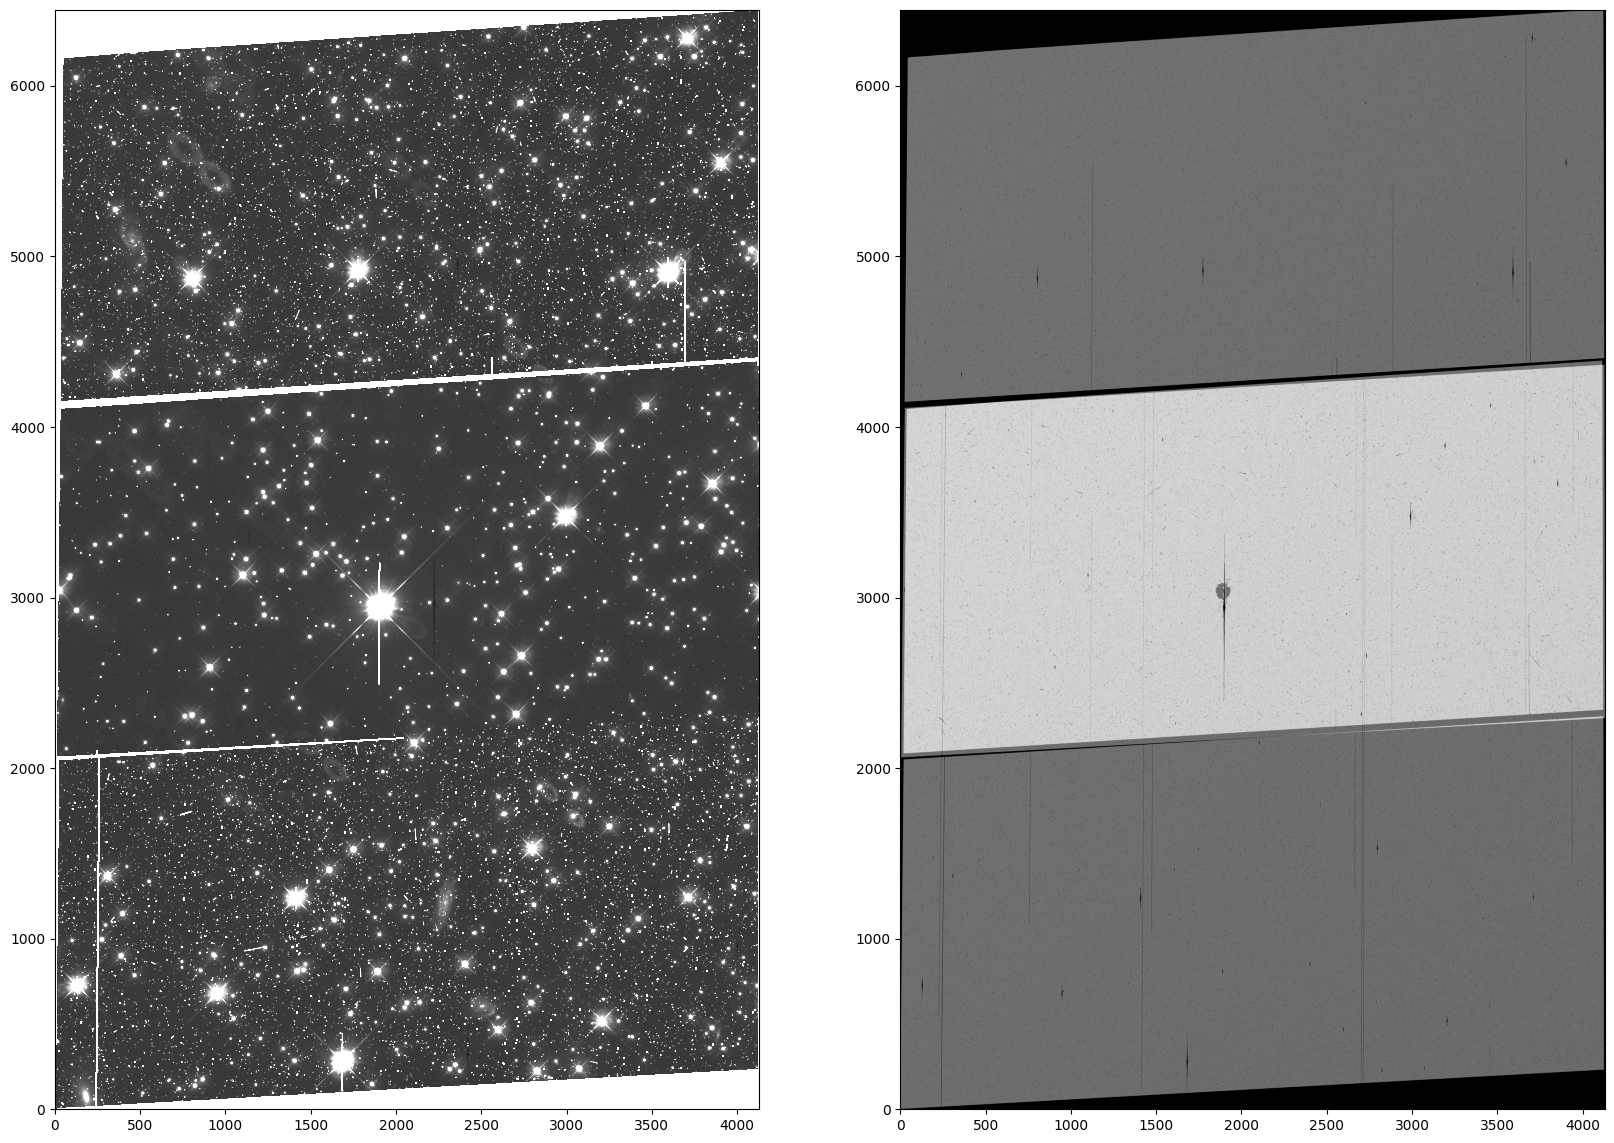

In [25]:
# Display the combined science and weight images 

sci = fits.getdata('f606w_drc_sci.fits')
wht = fits.getdata('f606w_drc_wht.fits')

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')
ax2.imshow(wht, vmin=0, vmax=1000, cmap='Greys_r', origin='lower')

## Conclusions

Many other services have interfaces for querying catalogs which could also be used to align HST images.  In general, Gaia works very well for HST due to it's high precision, but can have a low number of sources in some regions, especially at high galactic latitudes.  Aligning images to an absolute frame provides an easy way to make data comparable across many epochs/detectors/observatories, and in many cases, makes the alignment much easier.

# About this Notebook

    Author: V. Bajaj, STScI WFC3 Team
    Updated: December 14, 2018